# Movie Review Sentiment Analysis and Rating Prediction

In this homework, you will:
1. Load IMDB movie reviews dataset using Hugging Face datasets
2. Perform sentiment analysis
3. Build a ML model to predict movie ratings


In [48]:
# TODO: Install required packages
%pip install pandas numpy scikit-learn transformers torch datasets matplotlib seaborn

In [49]:
# TODO: Import required libraries
import pandas as pd
import numpy as np
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import re
from transformers import pipeline
import torch
import seaborn as sns
import matplotlib.pyplot as plt
# Add any other libraries you need

## Part 1: Load Dataset

Load the IMDB dataset using Hugging Face datasets library

In [50]:
# TODO: Load the IMDB dataset
load_dataset('imdb')
# Convert to pandas DataFrame for easier manipulation

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [51]:
dataset = load_dataset('imdb')
full_df = dataset['train'].to_pandas()
print(f"Original Dataset Shape: {full_df.shape}")
df_subset = full_df.sample(frac=.05)
print(f"Subset Dataset Shape: {df_subset.shape}")
df_subset = df_subset.reset_index(drop=True)
print(df_subset.head(25))

Original Dataset Shape: (25000, 2)
Subset Dataset Shape: (1250, 2)
                                                 text  label
0   I watched this movie with some friends a coupl...      0
1   All Hype! What better way to describe a movie ...      0
2   The movie follows the events of the novel "Cel...      1
3   I don't know if this is one of the SyFy Channe...      0
4   No one goes to a movie like The Hills Have Eye...      0
5   supposedly based on the life of Domino Harvey ...      0
6   This movie has everything that makes a bad mov...      1
7   ... than this ;-) What would happen if Terry G...      1
8   THE HOUSE THAT DRIPPED BLOOD is the third in a...      1
9   Angels who got a little icky were banned from ...      0
10  A story of obsessive love pushed to its limits...      1
11  I saw this movie, and at times, I was unnerved...      0
12  This thing is horrible. The Ben Affleck charac...      0
13  "Gone With The Wind" is one of the most overra...      0
14  i'm being gene

## Part 2: Data Preprocessing

Clean and prepare the text data

In [52]:
# TODO: Create a function to clean text
def clean_text(text):
    # 1. Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # 2. Remove special characters
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    # 3. Convert to lowercase
    text = text.lower()
    return text

# add new column of cleaned text and prove changes were made
df_subset['cleaned_text'] = df_subset['text'].apply(clean_text)
print(df_subset[['text', 'cleaned_text', 'label']].head())
# Hint: Use regular expressions

                                                text  \
0  I watched this movie with some friends a coupl...   
1  All Hype! What better way to describe a movie ...   
2  The movie follows the events of the novel "Cel...   
3  I don't know if this is one of the SyFy Channe...   
4  No one goes to a movie like The Hills Have Eye...   

                                        cleaned_text  label  
0  i watched this movie with some friends a coupl...      0  
1  all hype what better way to describe a movie a...      0  
2  the movie follows the events of the novel cel ...      1  
3  i dont know if this is one of the syfy channel...      0  
4  no one goes to a movie like the hills have eye...      0  


## Part 3: Advanced Sentiment Analysis

Go beyond binary classification - use a pre-trained model to get continuous sentiment scores

In [53]:
# from transformers import AutoTokenizer

# # 1. Load the tokenizer
# # This downloads the 'dictionary' the model uses to convert words to numbers
# tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

# # 2. Calculate token counts for every row
# # We use 'encode' to turn text into IDs, then count the length of that list
# df_subset['token_count'] = df_subset['cleaned_text'].apply(
#     lambda x: len(tokenizer.encode(x, add_special_tokens=True, truncation=False))
# )

# # 3. Get the specific count
# over_limit = df_subset[df_subset['token_count'] > 512]
# count = len(over_limit)
# percent = (count / len(df_subset)) * 100

# print(f"\n--- Token Count Report ---")
# print(f"Total Samples: {len(df_subset)}")
# print(f"Samples > 512 tokens: {count}")
# print(f"Percentage: {percent:.2f}%")

# # 4. (Optional) View the long reviews
# print("\nLongest review length:", df_subset['token_count'].max())

In [54]:


# 3. Filter the DataFrame
# We keep only rows where token_count is Less Than or Equal to 512
# We use .copy() to ensure we have a clean standalone dataframe, not a "view" of the old one
# df_filtered = df_subset[df_subset['token_count'] <= 512].copy()

# # 4. Reset the index
# # This prevents gaps in your index numbers (e.g., going from row 4 to row 6)
# df_filtered = df_filtered.reset_index(drop=True)

# # --- Verification ---
# print(f"Original size: {len(df_subset)}")
# print(f"Filtered size: {len(df_filtered)}")
# print(f"Dropped rows:  {len(df_subset) - len(df_filtered)}")
# print(f"Max token count in new data: {df_filtered['token_count'].max()}")

In [55]:
# TODO: Implement advanced sentiment analysis
# 1. Load a pre-trained model (hint: try 'distilbert-base-uncased-finetuned-sst-2-english')
sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model="distilbert-base-uncased-finetuned-sst-2-english",
    top_k=None,
    device=-1
)

# 2. Create a function to get continuous sentiment scores
def get_positive_score(text):
    results = sentiment_pipeline(text, truncation=True, max_length=512)

    scores = results[0]

    for item in scores:
        if item['label'] == 'POSITIVE':
            return item['score']
    return 0.0

# 3. Apply it to your cleaned text data
# Note: Original dataset has binary labels, but we want continuous scores!
df_subset = df_subset.copy()
df_subset['bert_score'] = df_subset['cleaned_text'].apply(get_positive_score)

# 4. View Results
print(df_subset[['label', 'bert_score', 'cleaned_text']].head())

Device set to use cpu



--- Scoring Complete ---
   label  bert_score                                       cleaned_text
0      0    0.000820  i watched this movie with some friends a coupl...
1      0    0.027464  all hype what better way to describe a movie a...
2      1    0.989424  the movie follows the events of the novel cel ...
3      0    0.001228  i dont know if this is one of the syfy channel...
4      0    0.063272  no one goes to a movie like the hills have eye...


## Part 4: Feature Engineering

Create rich features for your model

In [56]:
# TODO: Create features
# 1. Use your continuous sentiment scores
df_features = df_subset.copy()

# 2. Calculate text statistics:
#    - Length
df_features['review_length'] = df_features['text'].apply(len)

#    - Word count
df_features['word_count'] = df_features['cleaned_text'].apply(lambda x: len(x.split()))

#    - Average word length
def get_avg_word_len(text):
    words = text.split()
    if len(words) == 0:
        return 0
    word_lengths = [len(w) for w in words]
    return sum(word_lengths) / len(words)

df_features['avg_word_length'] = df_features['cleaned_text'].apply(get_avg_word_len)

#    - Sentence count
def count_sentences(text):
    sentences = re.split(r'[.!?]+', text)
    return max(1, len(sentences) - 1) # Ensure at least 1 sentence count if text exists

df_features['sentence_count'] = df_features['text'].apply(count_sentences)

# 3. Any other features you think might help!

# Exclamation count
# Indicates intensity of review
df_features['exclamation_count'] = df_features['text'].apply(lambda x: x.count('!'))

# Proper Noun Count
# Indicates fan engagement/movie knowledge, specificity, veracity, and spam detection
def count_estimated_proper_nouns(text):
    matches = re.findall(r'\b[A-Z][a-z]+\b', text)
    return len(matches)

df_features['proper_noun_count'] = df_features['text'].apply(count_estimated_proper_nouns)

# remove sentence starters from the count
df_features['proper_noun_adj'] = df_features.apply(
    lambda row: max(0, row['proper_noun_count'] - row['sentence_count']),
    axis=1
)


## Part 5: Multi-Class Rating Prediction

Instead of binary classification, predict a 5-star rating!

In [57]:
# TODO: Create target variable
# Convert binary labels to 5-star ratings using your features
# Hint: Use sentiment scores and other features to estimate star rating

def calculate_weighted_star_rating(row):
    raw_stars = (row['bert_score'] * 4) + 1

    # Specificity Bonus - add 0.1 stars for every specific name mentioned,
    # cap bonus at +1.0 star so a list of names doesn't break the scale.
    specificity_bonus = min(1.0, row['proper_noun_adj'] * 0.1)

    current_stars = raw_stars + specificity_bonus

    # Intensity Adjustments -exclamations push the score to extremes
    if row['exclamation_count'] > 2:
        if current_stars > 3.5:
            current_stars += 0.5
        elif current_stars < 2.0:
            current_stars -= 0.5

    final_stars = round(current_stars)
    return int(max(1, min(5, final_stars)))

df_features['star_rating_weighted'] = df_features.apply(calculate_weighted_star_rating, axis=1)
print(df_features[['bert_score', 'word_count', 'sentence_count', 'exclamation_count', 'proper_noun_adj', 'star_rating_weighted']].head())

   bert_score  word_count  sentence_count  exclamation_count  proper_noun_adj  \
0    0.000820         135               8                  0                0   
1    0.027464         122              11                  2                1   
2    0.989424         104               4                  0                9   
3    0.001228         334              18                  0               15   
4    0.063272         456              20                  0               45   

   star_rating_weighted  
0                     1  
1                     1  
2                     5  
3                     2  
4                     2  


In [58]:
# TODO: Build and train your model
# 1. Split data into train and test sets
feature_cols = ['bert_score', 'word_count', 'sentence_count', 'exclamation_count', 'proper_noun_adj']

X = df_features[feature_cols]
y = df_features['star_rating_weighted']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)

# 2. Choose a model suitable for multi-class classification
# Build 100 different decision trees and vote on the result
rf_model = RandomForestClassifier(n_estimators=100, random_state=99)

# 3. Train the model
rf_model.fit(X_train, y_train)

# 4. Make Predictions
y_pred = rf_model.predict(X_test)

# 5. Evaluate Performance
print("\nAccuracy Score")
print(f"{accuracy_score(y_test, y_pred):.4f}")

print("\nClassification Report")
print(classification_report(y_test, y_pred))



Accuracy Score
0.9920

Classification Report
              precision    recall  f1-score   support

           1       0.98      1.00      0.99        63
           2       1.00      0.99      0.99        81
           3       1.00      1.00      1.00         3
           4       0.67      1.00      0.80         2
           5       1.00      0.99      1.00       101

    accuracy                           0.99       250
   macro avg       0.93      1.00      0.96       250
weighted avg       0.99      0.99      0.99       250



## Part 6: Analysis

Analyze your results and suggest improvements

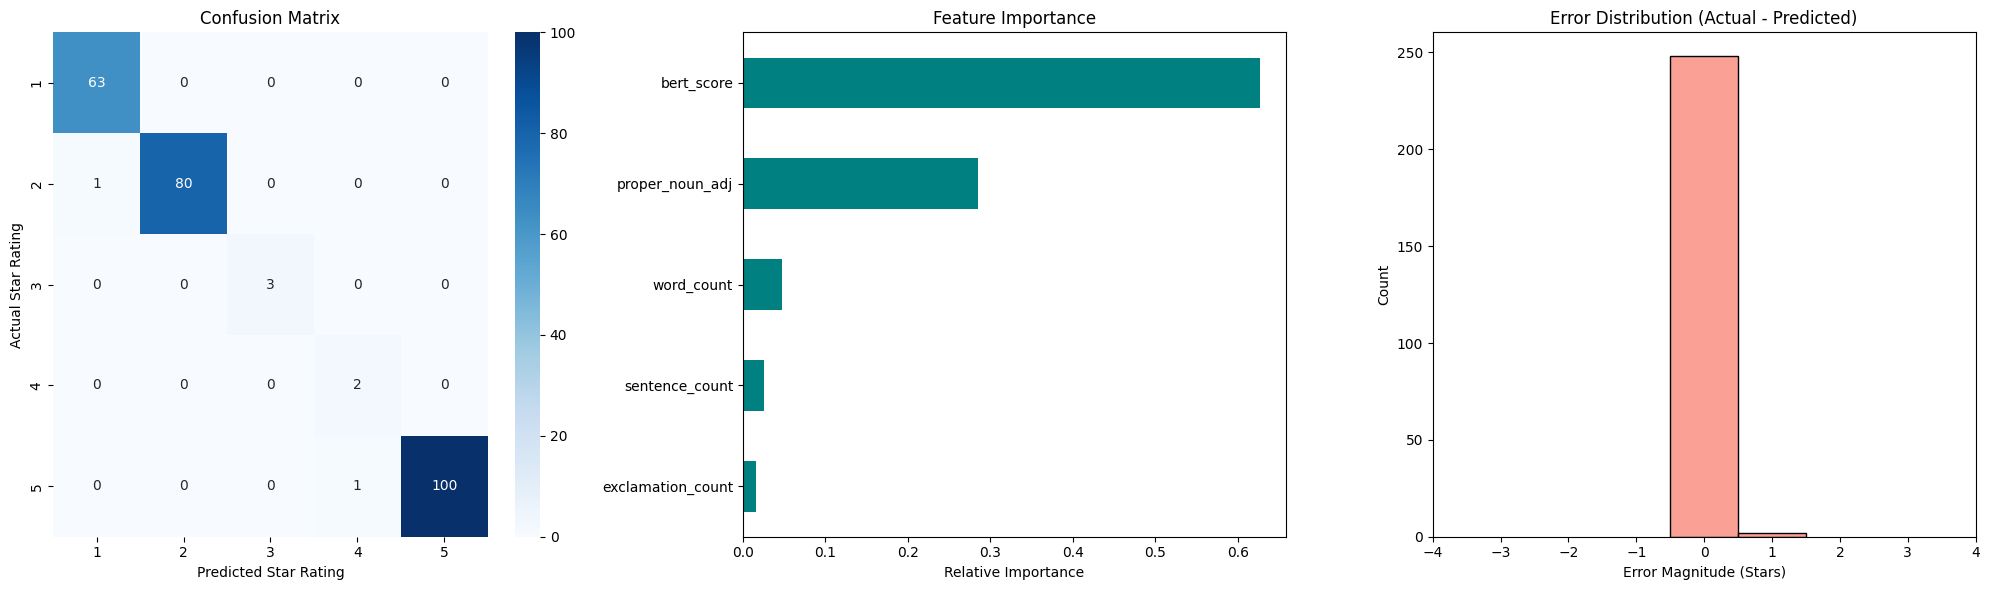

In [59]:
# TODO: Create visualizations and analyze:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# 1. Confusion matrix for multi-class predictions
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=[1, 2, 3, 4, 5], yticklabels=[1, 2, 3, 4, 5])
axes[0].set_title('Confusion Matrix')
axes[0].set_xlabel('Predicted Star Rating')
axes[0].set_ylabel('Actual Star Rating')

# 2. Feature importance
importances = pd.Series(rf_model.feature_importances_, index=feature_cols)
importances.sort_values().plot(kind='barh', color='teal', ax=axes[1])
axes[1].set_title('Feature Importance')
axes[1].set_xlabel('Relative Importance')

# 3. Error analysis
errors = y_test - y_pred
sns.histplot(errors, bins=np.arange(-4.5, 5.5, 1), discrete=True, color='salmon', ax=axes[2])
axes[2].set_title('Error Distribution (Actual - Predicted)')
axes[2].set_xticks(range(-4, 5))
axes[2].set_xlabel('Error Magnitude (Stars)')

plt.tight_layout()
plt.show()



4. Suggested Improvements

A high majority of the reviews ended in 1,2, or 5 stars. People who write movie reviews for free on imdb probably have strong opinions about the movies they take the time to write about.

Suggest giving different weights to high-end and low-end sentiment scores to balance the star ratings on reviews to be less polarizing.